# Quick tests outside of Test macro

In [1]:
using TestEnv
TestEnv.activate()

"/tmp/jl_3J0wFh/Project.toml"

In [3]:
using GalacticDynamics
using Test
using PythonCall
using CairoMakie
using BenchmarkTools
using Profile, ProfileSVG


pyimport("sys")."path".append("")
pyimport("sys")."path".append("../python")
accelerations_py = pyimport("accelerations")
au = pyimport("astropy.units")
gd = pyimport("gala.dynamics")
gp = pyimport("gala.potential")
gu = pyimport("gala.units")
gi = pyimport("gala.integrate")

Python: <module 'gala.integrate' from '/home/mmestre/.conda/envs/cosmos/lib/python3.11/site-packages/gala/integrate/__init__.py'>

#### Setting up initial conditions and potentials in both Gala and GalacticDynamics

In [4]:
Δt = 0.01
n_step = 1000
t₁ = 0.0
t₂ = t₁ + n_step*Δt
@show t₂
t_range = (t₁, t₂)
x₀ = -50.0*SA[1,0,0]
v₀ = 200.0*SA[0,1,0]
# x₀ = 30*[1,0,1]
# v₀ = 100*[0,1,0]
m = 10.0^12*𝕦.m  # Msun
a = 20.0*𝕦.l
pot = NFW(m, a)
c = concentration(pot)
f(x) = log(1+x)-x/(1+x)
m_g = m/f(c)
usys = gu.UnitSystem(au.kpc, au.Gyr, au.Msun, au.radian, au.kpc/au.Gyr, au.kpc/au.Gyr^2)
pot_Gala = gp.NFWPotential(Py(adimensional(m_g))*au.Msun, Py(adimensional(a))*au.kpc, units=usys)
w₀ = gd.PhaseSpacePosition(pos=Py(x₀)*au.kpc, vel=Py(v₀)*au.kpc/au.Gyr)

t₂ = 10.0


Python: <PhaseSpacePosition cartesian, dim=3, shape=()>

### Orbit plot with Gala and GalacticDynamics


𝕤.ode = Vern9(; stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false), lazy = true,)
sol_gala.t[-1] = <py Quantity 10. Gyr>
sol.t[end] = 10.0
findmax(sol_diff) = (0.00039413660635911896, 978)


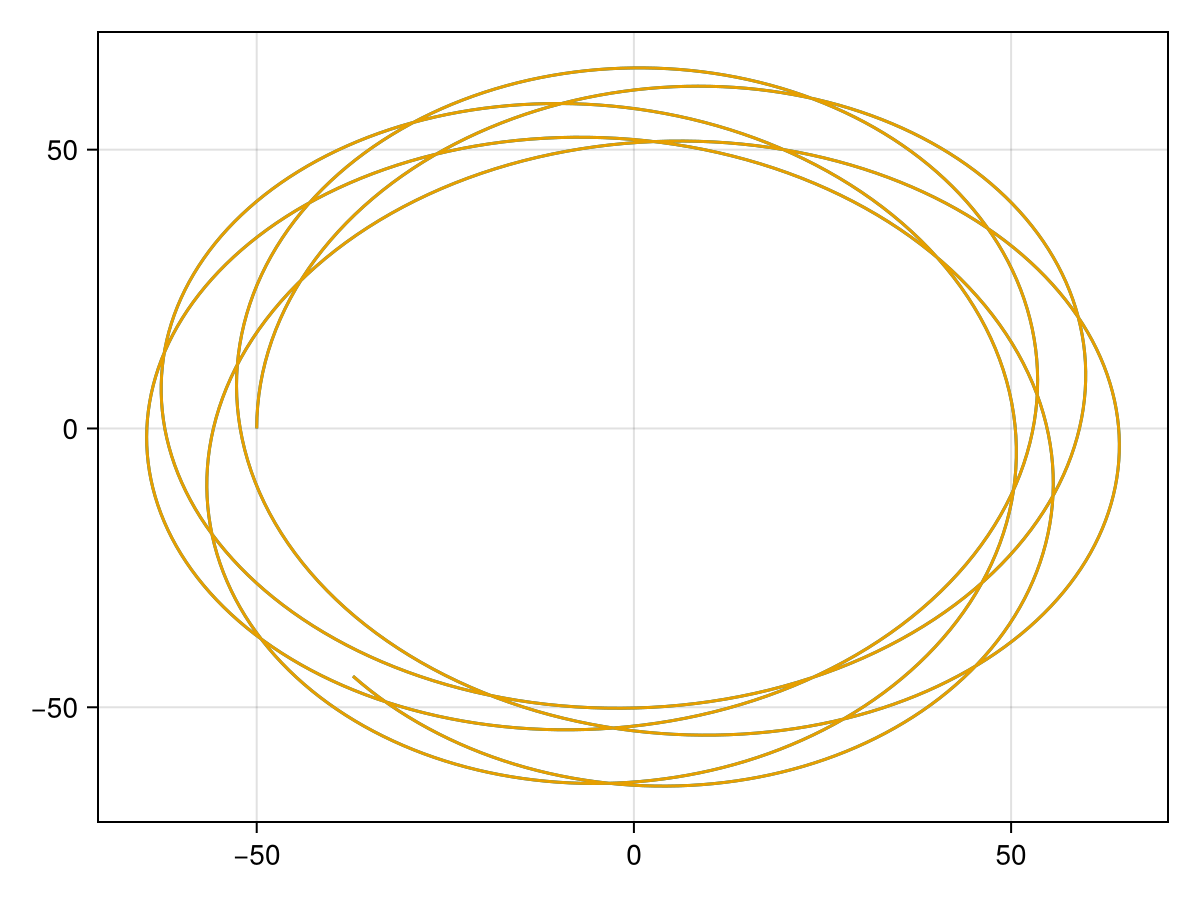

In [5]:
sol_gala = pot_Gala.integrate_orbit(w₀, dt=Δt*au.Gyr, t1=t₁, t2=(t₂+1.e-7)*au.Gyr,
                                    Integrator=gi.DOPRI853Integrator,cython_if_possible=true,
                                    Integrator_kwargs=Py(Dict("rtol"=>5.0e-8)))
sol = evolve(pot, x₀, v₀, t_range, DP8(); options=ntSolverOptions(;reltol=5.0e-8, saveat=Δt))

@show 𝕤.ode
@show sol_gala.t[-1]
@show sol.t[end]
orb_gala_x = pyconvert(Vector{Float64}, sol_gala.x)
orb_gala_y = pyconvert(Vector{Float64}, sol_gala.y)
orb_x = sol.x[1,:]
orb_y = sol.x[2,:]
sol_diff = abs.(orb_gala_x-orb_x)
@show findmax(sol_diff)
lines(orb_gala_x,orb_gala_y)
lines!(orb_x,orb_y)
current_figure()



### Precision

#### Precision test between Gala and GalacticDynamics
##### For the NFW
Adding `atol=0.5e-16` in both Gala and GalacticDynamics improves the precision by two orders of magnitude, only when `rtol` is already very small (`< 10^{-16}`).

In [6]:
orb₁ = pot_Gala.integrate_orbit(w₀, dt=Δt*au.Gyr, t1=t₁, t2=t₂*au.Gyr,
                                Integrator=gi.DOPRI853Integrator,
                                Integrator_kwargs=Py(Dict("rtol"=>5.0e-8)))
orb₂ = pot_Gala.integrate_orbit(w₀, dt=Δt*au.Gyr, t1=t₁, t2=(t₂)*au.Gyr,
                                Integrator=gi.DOPRI853Integrator,
                                Integrator_kwargs=Py(Dict("rtol"=>5.0e-11)))
orb₃ = pot_Gala.integrate_orbit(w₀, dt=Δt*au.Gyr, t1=t₁, t2=(t₂)*au.Gyr,
                                Integrator=gi.DOPRI853Integrator,
                                Integrator_kwargs=Py(Dict("rtol"=>5.0e-20, "atol"=>0.5e-20)))
orb₄ = evolve(pot, x₀, v₀, t_range, Vern7(); options=ntSolverOptions(;reltol=5.0e-8, saveat=Δt))
orb₅ = evolve(pot, x₀, v₀, t_range, Vern7(); options=ntSolverOptions(;reltol=5.0e-11,saveat=Δt))
orb₆ = evolve(pot, x₀, v₀, t_range, Vern7(); options=ntSolverOptions(;reltol=5.0e-16, abstol=0.5e-16, saveat=Δt))
orb₇ = evolve(pot, x₀, v₀, t_range, Vern9(); options=ntSolverOptions(;reltol=5.0e-6, saveat=Δt))
orb₈ = evolve(pot, x₀, v₀, t_range, Vern9(); options=ntSolverOptions(;reltol=5.0e-11,saveat=Δt))
orb₉ = evolve(pot, x₀, v₀, t_range, Vern9(); options=ntSolverOptions(;reltol=5.0e-16, abstol=0.5e-16,
saveat=Δt))
@show orb₁.x[-1]  orb₂.x[-1]  orb₃.x[-1]
@show orb₄.x[1,end]  orb₅.x[1,end]  orb₆.x[1,end]
@show orb₇.x[1,end]  orb₈.x[1,end]  orb₉.x[1,end]
@show orb₄.x[1,end]-orb₁.x[-1].value  orb₅.x[1,end]-orb₂.x[-1].value  orb₆.x[1,end]-orb₃.x[-1].value
@show orb₇.x[1,end]-orb₁.x[-1].value  orb₈.x[1,end]-orb₂.x[-1].value  orb₉.x[1,end]-orb₃.x[-1].value
@show orb₇.x[1,end]-orb₄.x[1,end]  orb₈.x[1,end]-orb₅.x[1,end]  orb₉.x[1,end]-orb₆.x[1,end]
@test orb₄.x[1,end] ≈ pyconvert(Float64,orb₁.x[-1].value)  rtol=5.0e-8
@test orb₅.x[1,end] ≈ pyconvert(Float64,orb₂.x[-1].value)  rtol=5.0e-10
@test orb₆.x[1,end] ≈ pyconvert(Float64,orb₃.x[-1].value)  rtol=5.0e-12


orb₁.x[-1] = <py Quantity -37.23718442 kpc>
orb₂.x[-1] = <py Quantity -37.23718442 kpc>
orb₃.x[-1] = <py Quantity -37.23718442 kpc>
orb₄.x[1, end] = -37.237185772998345
orb₅.x[1, end] = -37.237184420460025
orb₆.x[1, end] = -37.2371844195847
orb₇.x[1, end] = -37.23739034144379
orb₈.x[1, end] = -37.237184420997416
orb₉.x[1, end] = -37.237184419581304
orb₄.x[1, end] - (orb₁.x[-1]).value = <py -1.353432267592325e-06>
orb₅.x[1, end] - (orb₂.x[-1]).value = <py -8.939480267144972e-10>
orb₆.x[1, end] - (orb₃.x[-1]).value = <py -1.709565822238801e-11>
orb₇.x[1, end] - (orb₁.x[-1]).value = <py -0.00020592187771484305>
orb₈.x[1, end] - (orb₂.x[-1]).value = <py -1.4313386031972186e-09>
orb₉.x[1, end] - (orb₃.x[-1]).value = <py -1.3699263945454732e-11>
orb₇.x[1, end] - orb₄.x[1, end] = -0.00020456844544725072
orb₈.x[1, end] - orb₅.x[1, end] = -5.373905764827214e-10
orb₉.x[1, end] - orb₆.x[1, end] = 3.396394276933279e-12


Test Passed

#### Precision test between Gala and GalacticDynamics
##### For the MN disk

In [6]:
gp = pyimport("gala.potential")
gd= pyimport("gala.dynamics")
gu = pyimport("gala.units")
pot_mn = gp.MiyamotoNagaiPotential(m=2.5E11*au.Msun, a=6.5*au.kpc,b=0.26*au.kpc, units=gu.galactic)
w0 = gd.PhaseSpacePosition(pos=Py([11., 0., 0.2])*au.kpc, vel=Py([0., 200, 100])*au.km/au.s)
orb₁ = pot_mn.integrate_orbit(w0, dt=1., n_steps=1000, Integrator=gi.DOPRI853Integrator)
orb₂ = pot_mn.integrate_orbit(w0, dt=1., n_steps=1000, Integrator=gi.DOPRI853Integrator, Integrator_kwargs=Py(Dict("rtol"=>5.0e-15)))
orb₃_c = pot_mn.integrate_orbit(w0, dt=1., n_steps=1000, Integrator=gi.DOPRI853Integrator,  cython_if_possible=true, Integrator_kwargs=Py(Dict("rtol"=>5.0e-5)))
orb₃ = pot_mn.integrate_orbit(w0, dt=1., n_steps=1000, Integrator=gi.DOPRI853Integrator, Integrator_kwargs=Py(Dict("rtol"=>5.0e-5)))
orb₄ = pot_mn.integrate_orbit(w0, dt=1., n_steps=1000, Integrator=gi.LeapfrogIntegrator)
orb₅ = pot_mn.integrate_orbit(w0, dt=1., n_steps=1000, Integrator=gi.LeapfrogIntegrator, Integrator_kwargs=Py(Dict("rtol"=>5.0e-15)))
@show orb₁.x[-1] orb₂.x[-1] orb₃_c.x[-1] orb₃.x[-1]  orb₄.x[-1] orb₅.x[-1];

orb₁.x[-1] = <py Quantity 6.76980261 kpc>
orb₂.x[-1] = <py Quantity 6.76980261 kpc>
orb₃_c.x[-1] = <py Quantity 6.76980252 kpc>
orb₃.x[-1] = <py Quantity 6.76980252 kpc>
orb₄.x[-1] = <py Quantity 6.74183738 kpc>
orb₅.x[-1] = <py Quantity 6.74183738 kpc>


#### This is another NFW orbit test that originally couldn't be integrated in Julia due to abrupt reduction of step size.
#### Problem solved: I was taking an initial condition that with radial orbit!

In [28]:
usys = gu.UnitSystem(au.kpc, au.Gyr, au.Msun, au.radian, au.kpc/au.Gyr, au.kpc/au.Gyr^2)
Δt = 0.01
n_step = 1000
t₁ = 0.0
t₂ = t₁ + n_step*Δt
@show t₂
t_range = (t₁, t₂)

x₀ = 30*[1,0,1]
v₀ = 200*[0,1,0]
m = 10^12*𝕦.m  # Msun
a = 20*𝕦.l
pot = NFW(m, a)
c = concentration(pot)
f(x) = log(1+x)-x/(1+x)
m_g = m/f(c)
pot_Gala = gp.NFWPotential(Py(adimensional(m_g))*au.Msun, Py(adimensional(a))*au.kpc, units=usys)
@show pot_Gala

# Gala.py solution
w₀ = gd.PhaseSpacePosition(pos=Py(x₀)*au.kpc, vel=Py(v₀)*au.kpc/au.Gyr)
orb_gala = pot_Gala.integrate_orbit(w₀, dt=Δt*au.Gyr, t1=t₁, t2=(t₂)*au.Gyr,
Integrator=gi.DOPRI853Integrator,Integrator_kwargs=Py(Dict("rtol"=>5.0e-14, "atol"=>0.5e-14)))
orb_gala_t = pyconvert(Vector{Float64}, orb_gala.t)
orb_gala_x = pyconvert(Vector{Float64}, orb_gala.x)
orb_gala_y = pyconvert(Vector{Float64}, orb_gala.y)
orb_gala_z = pyconvert(Vector{Float64}, orb_gala.z)
# GalacticDynamics.jl solution
sol = evolve(pot, x₀, v₀, t_range, Vern9(); options=ntSolverOptions(; reltol=5.0e-14, abstol=0.5e-14, saveat=Δt))
@show sol.t
orb_t = ustrip.(physical_units.(sol.t,:t))
orb_x = sol.x[1,:]

@test orb_t[end] ≈ orb_gala_t[end] rtol=5.0e-12
@test orb_x[end] ≈ orb_gala_x[end] rtol=5.0e-12

t₂ = 10.0
pot_Gala = <py NFWPotential: m=6.52e+11, r_s=20.00, a=1.00, b=1.00, c=1.00 (kpc,Gyr,solMass,rad)>
sol.t = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0, 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09, 1.1, 1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2, 1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3, 1.31, 1.32, 1.33, 1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.4, 1.41, 1.42, 1.43, 1.44, 1.45, 1.46, 1.47, 1.48, 1.49

Test Passed

### Speed tests

#### BenchmarkTools only tests memory consumption on the Julia side. The time is real as long as C is not working asynchronously.

In [181]:
@benchmark pot_Gala.integrate_orbit(w₀, dt=Δt*au.Gyr, t1=t₁, t2=(t₂)*au.Gyr,
                                    Integrator=gi.DOPRI853Integrator,
                                    Integrator_kwargs=Py(Dict("rtol"=>5.0e-16, "atol"=>0.5e-16)))

BenchmarkTools.Trial: 261 samples with 1 evaluation.
 Range (min … max):  18.234 ms … 27.463 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     18.869 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   19.180 ms ±  1.125 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

     ▅▇█▇▃ ▁▁                                                  
  ▂▄▇████████▄▄▄▅▃▃▃▂▃▂▃▁▁▁▁▁▁▁▃▃▂▂▁▁▁▁▂▂▁▂▁▁▁▁▂▁▁▃▁▁▁▁▁▁▁▁▁▂ ▃
  18.2 ms         Histogram: frequency by time        23.9 ms <

 Memory estimate: 3.02 KiB, allocs estimate: 141.

In [182]:
@benchmark pot_Gala.integrate_orbit(w₀, dt=Δt*au.Gyr, t1=t₁, t2=(t₂)*au.Gyr,
                                    Integrator=gi.DOPRI853Integrator,
                                    cython_if_possible=true,
                                    Integrator_kwargs=Py(Dict("rtol"=>5.0e-16, "atol"=>0.5e-16)))


BenchmarkTools.Trial: 262 samples with 1 evaluation.
 Range (min … max):  18.252 ms … 43.710 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     18.947 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   19.063 ms ±  1.556 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

                  ▁ ▂ ▄▁▁▁▆ ▇▁▄█▁▁    ▁  ▁▁                    
  ▃▁▁▁▁▃▅▁▃▃▅▆▁▅▅▅█▅█▅█████▆██████▆▅▅▄█▃▇██▅▄▆▇▄▄▃▃▃▃▁▁▃▃▁▁▁▃ ▄
  18.3 ms         Histogram: frequency by time        19.8 ms <

 Memory estimate: 3.26 KiB, allocs estimate: 144.

In [187]:
@benchmark evolve(pot, x₀, v₀, t_range, Vern7(); options=ntSolverOptions(;reltol=5.0e-16, abstol=0.5e-16, saveat=Δt))

BenchmarkTools.Trial: 339 samples with 1 evaluation.
 Range (min … max):  13.523 ms … 22.993 ms  ┊ GC (min … max): 0.00% … 37.89%
 Time  (median):     14.357 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   14.748 ms ±  1.210 ms  ┊ GC (mean ± σ):  0.51% ±  2.81%

      ▄▆█▁                                                     
  ▃▄▄██████▅▇▇▅▆▆▄▄▄▃▃▂▃▃▂▂▃▁▁▁▂▃▂▁▂▁▁▂▁▁▂▁▁▂▂▁▁▂▁▁▁▁▂▁▁▁▁▁▂▃ ▃
  13.5 ms         Histogram: frequency by time        20.4 ms <

 Memory estimate: 2.77 MiB, allocs estimate: 148.

In [195]:
@benchmark evolve(pot, x₀, v₀, (t₁,t₂/10), DP8(); options=ntSolverOptions(;reltol=5.0e-16, saveat=Δt))

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  339.540 μs …   7.443 ms  ┊ GC (min … max): 0.00% … 87.05%
 Time  (median):     368.606 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   397.793 μs ± 197.694 μs  ┊ GC (mean ± σ):  3.10% ±  6.06%

    █▇▄                                                          
  ▃▅███▇▆▆▅▄▅▅▅▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  340 μs           Histogram: frequency by time          646 μs <

 Memory estimate: 283.80 KiB, allocs estimate: 144.

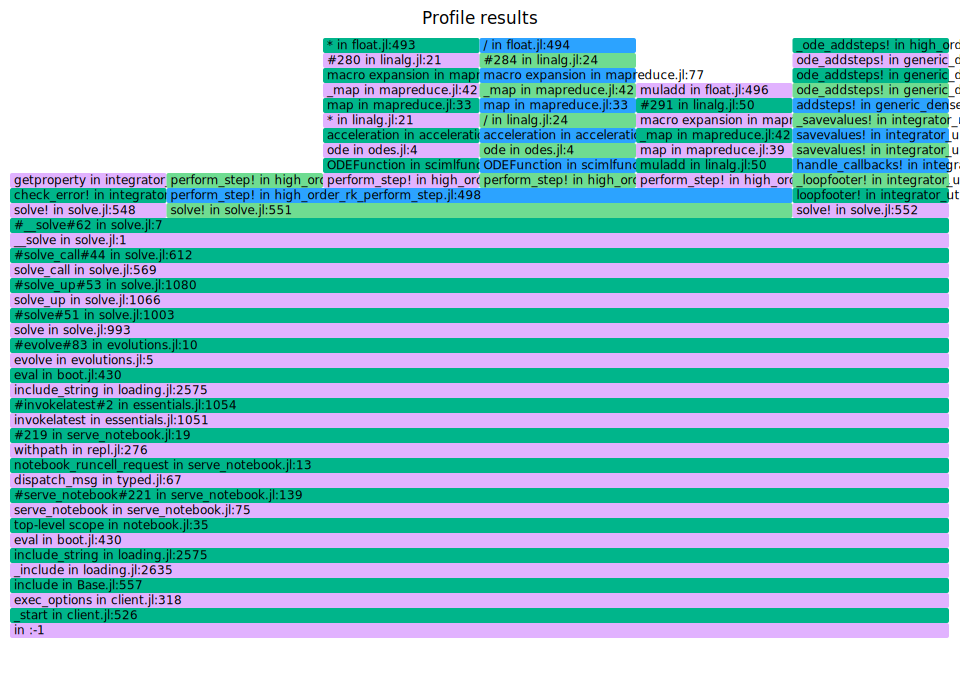

In [19]:
ProfileSVG.@profview evolve(pot, x₀, v₀, t_range, DP8(); options=ntSolverOptions(; reltol=5.0e-16, abstol=0.5e-16, saveat=Δt))

In [ ]:
@profview evolve(pot, x₀, v₀, t_range, DP8(); options=ntSolverOptions(; reltol=5.0e-16, abstol=0.5e-16, saveat=Δt))